합성곱 신경망의 학습 시각화 : 합성곱 신경망 모델을 읽어 들인 후 이 모델의 가중치와 특성 맵을 시각화

#### 1. 합성곱 층의 가중치 시각화
합성곱 신경망은 주로 이미지를 다루기 때문에 가중치가 시각적인 패턴을 학습하는지 알아볼 수 있음

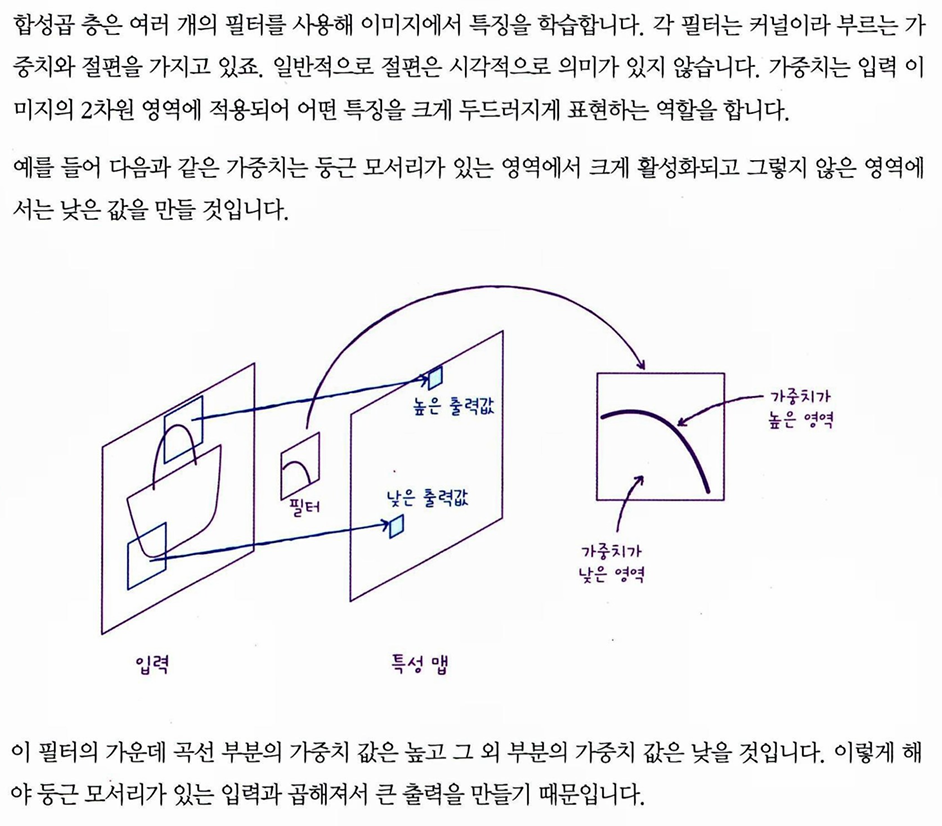

In [1]:
# 체크포인트 파일을 읽기
import keras
model = keras.models.load_model('best-cnn-model.keras')

2025-11-27 09:09:45.750944: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 09:09:46.090032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764202186.218715    2651 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764202186.257435    2651 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-27 09:09:46.459194: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
model.layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>]

In [ ]:
# 첫 번째 합성곱 층
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape) # 층의 가중치와 절편의 크기
# 커널크기(3,3,1), 필터개수 32


(3, 3, 1, 32) (32,)


In [4]:
# Tensor 클래스의 객체인 weights 속성을 넘파이 배열로 변환
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std()) # 평균과 표준편차

-0.010761491 0.14335044


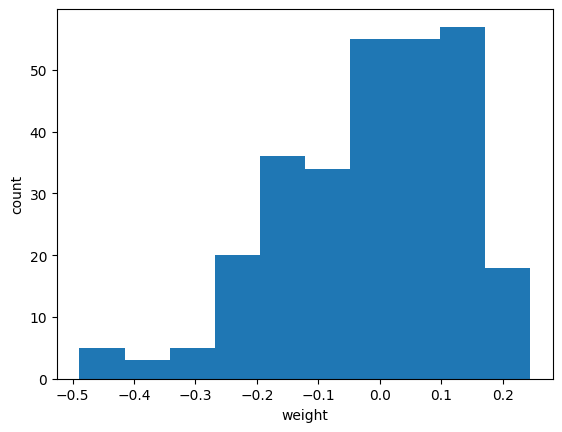

In [ ]:
# 가중치가 어떤 분포를 가졌는지 히스토그램 그리기
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1)) # 히스토그램을 그리기 위해 1차원 배열로 전달해야 함
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

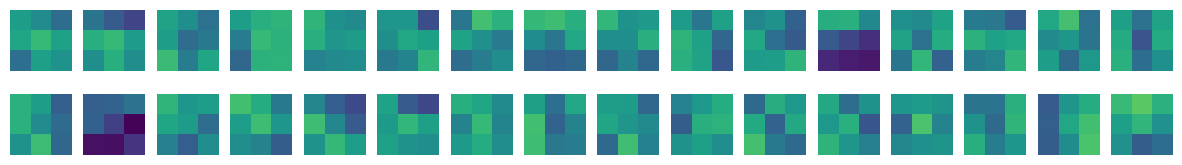

In [ ]:
# 32개의 커널을 16개씩 두 줄에 출력
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        # conv_weights 배열의 마지막 차원을 순회하면서 0부터 i*16+j번째까지의 가중치 값을 차례대로 출력
        # conv_weights[：,：,0,0]에서 conv_weights[：, ：,0,31]까지 출력
        # imshow() : 배열에 있는 최댓값과 최솟값을 사용해 픽셀의 강도를 표현
        axs[i, j].imshow(conv_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5) # vmin과 vmax로 맷플롯립의 컬러맵으로 표현할 범위를 지정
        axs[i, j].axis('off')
plt.show()

In [7]:
# 훈련하지 않은 빈 합성곱 신경망 생성
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Input(shape=(28,28,1)))
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'))

In [8]:
# 모델의 첫 번째 층(즉 Conv2D 층)의 가중치를 no_training_conv 변수에 저장
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape) # 가중치의 크기

(3, 3, 1, 32)


In [9]:
# 가중치의 평균과 표준편차 확인
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std()) 

0.0034538757 0.08266098


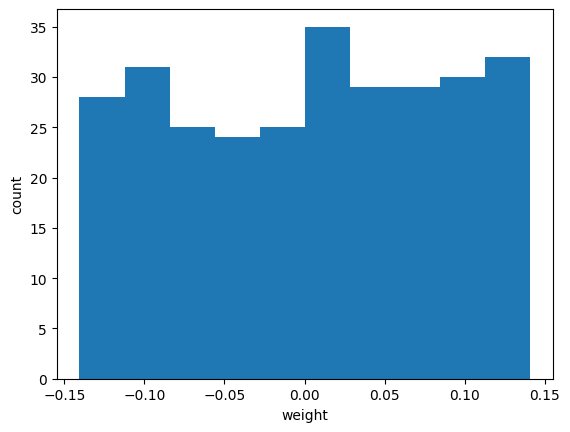

In [ ]:
# 가중치 배열을 히스토그램으로 표현
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()
# 대부분의 가중치가 -0.15〜0.15 사이에 있고 비교적 고른 분포를 보임 -> 케라스가 신경망의 가중치를 처음 초기화할 때 균등 분포에서 랜덤하게 값을 선택하기 때문

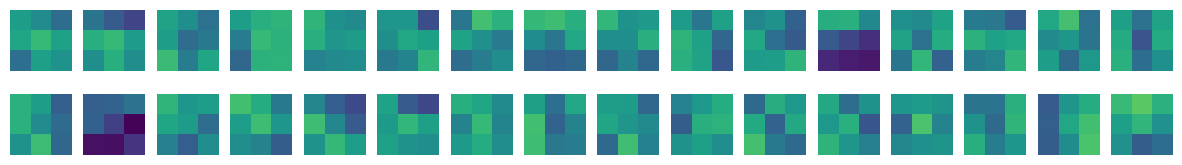

In [12]:
# 32개의 커널을 16개씩 두 줄에 출력
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        # conv_weights 배열의 마지막 차원을 순회하면서 0부터 i*16+j번째까지의 가중치 값을 차례대로 출력
        # conv_weights[：,：,0,0]에서 conv_weights[：, ：,0,31]까지 출력
        axs[i, j].imshow(conv_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5) 
        axs[i, j].axis('off')
plt.show()

####  2. 합성곱 층에서 출력된 특성 맵 시각화
합성곱 층의 활성화 출력을 이미지로 그리는 것. 가중치 시각화와 함께 비교하여 각 필터가 이미지의 어느 부분을 활성화시키는지 확인 가능

##### 함수형 API
- 케라스에서 신경망 모델을 만드는 방법 중 하나
- 함수형 API를 사용하면 복잡한 조합의 모델을 자유롭게 구성 가능 (케라스 Sequential 클래스를 사용하면 층을 차례대로 쌓은 모델 생성)
- 여기서는 입력과 합성곱 층의 출력을 연결하여 특성 맵을 시각화하기 위한 용도로 사용

In [13]:
# Dense층 2개로 이루어진 완전 연결 신경망을 함수형 API로 구현
inputs = keras.Input(shape=(784,))
dense1 = keras.layers.Dense(100, activation='relu')
dense2 = keras.layers.Dense(10, activation='softmax')

In [14]:
# 입력값 inputs를 Dense층에 통과시킨 후 출력값 hidden 생성
hidden = dense1(inputs)

In [15]:
# 첫 번째 층의 출력을 입력으로 하는 두 번째 층 호출
outputs = dense2(hidden)

In [ ]:
# inputs와 outputs을 Model 클래스로 연결
func_model = keras.Model(inputs, outputs)

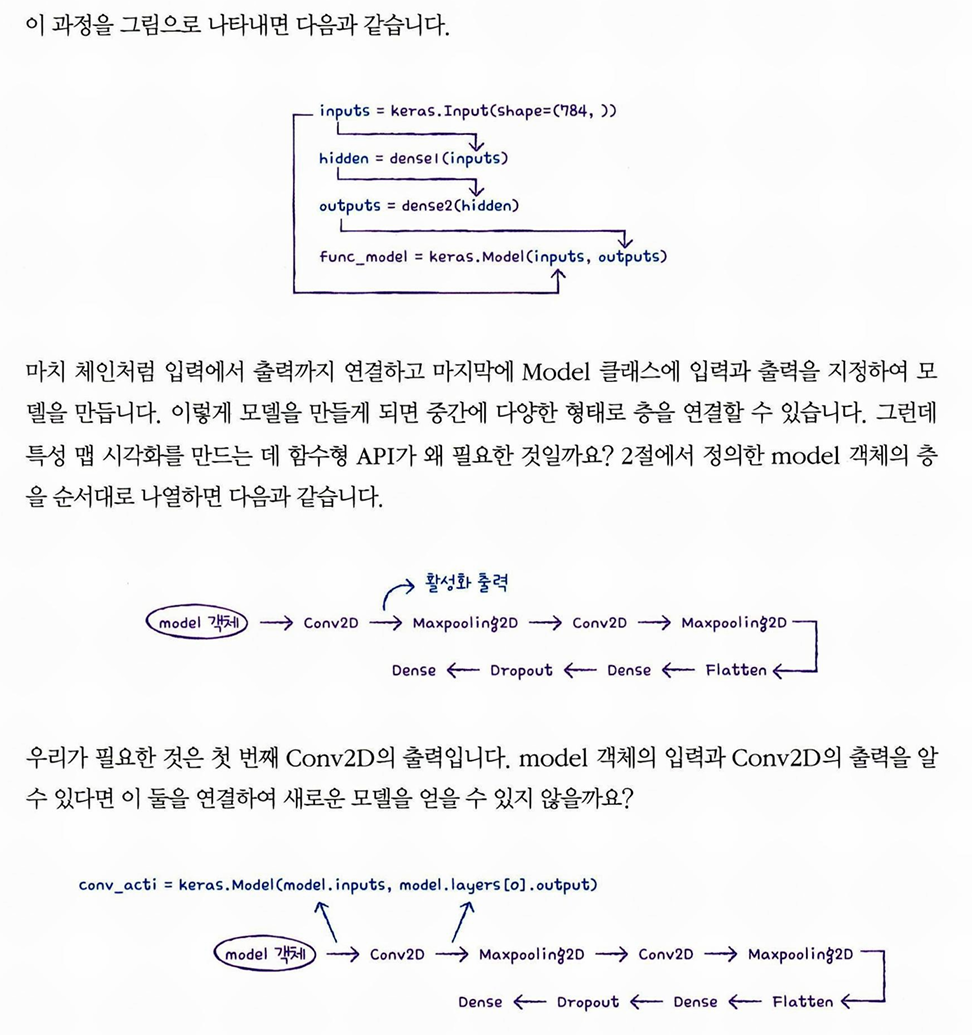
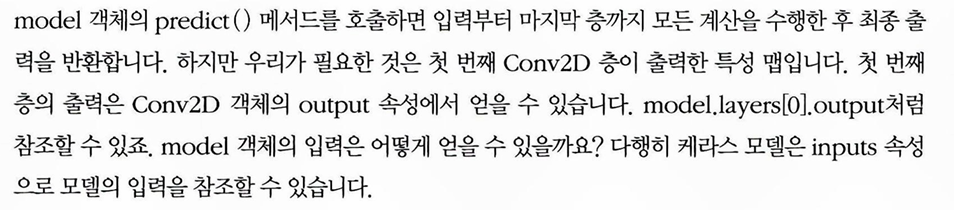

In [17]:
# model 객체의 입력
print(model.inputs)

[<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=input_layer>]


In [18]:
# model.inputs의 첫 번째 원소와 model.layers[0].output을 연결하는 새로운 conv_acti 모델 생성
conv_acti = keras.Model(model.inputs[0], model.layers[0].output)

##### 특성 맵 시각화

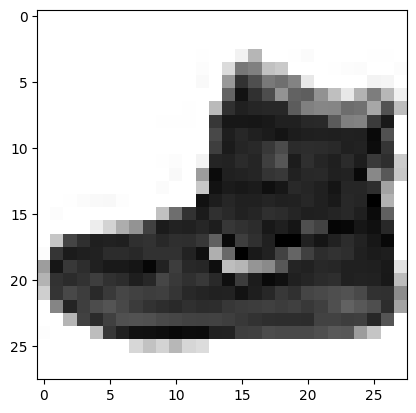

In [20]:
# 케라스로 패션 MNIST 데이터셋을 읽은 후 훈련 세트에 있는 첫 번째 샘플 그리기
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [21]:
# 이 샘플을 conv_acti 모델에 주입하여 Conv2D 층이 만드는 특성 맵을 출력
# predict() 메서드는 항상 입력의 첫 번째 차원이 배치 차원일 것으로 기대하므로 하나의 샘플을 전달하더라도 꼭 첫 번째 차원을 유지해야 함
ankle_boot = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0 # reshape(-1, 28, 28, 1)  : (28, 28)크기를(28, 28, 1) 크기로 변경
feature_maps = conv_acti.predict(ankle_boot)

I0000 00:00:1764205934.745196    2817 service.cc:148] XLA service 0x700f5c004ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764205934.745671    2817 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 4GB Laptop GPU, Compute Capability 8.6
2025-11-27 10:12:14.766233: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764205934.802949    2817 cuda_dnn.cc:529] Loaded cuDNN version 91002


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


I0000 00:00:1764205935.614986    2817 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [22]:
# feature_maps의 크기 확인
# 첫 번째 차원은 배치 차원
print(feature_maps.shape)

(1, 28, 28, 32)


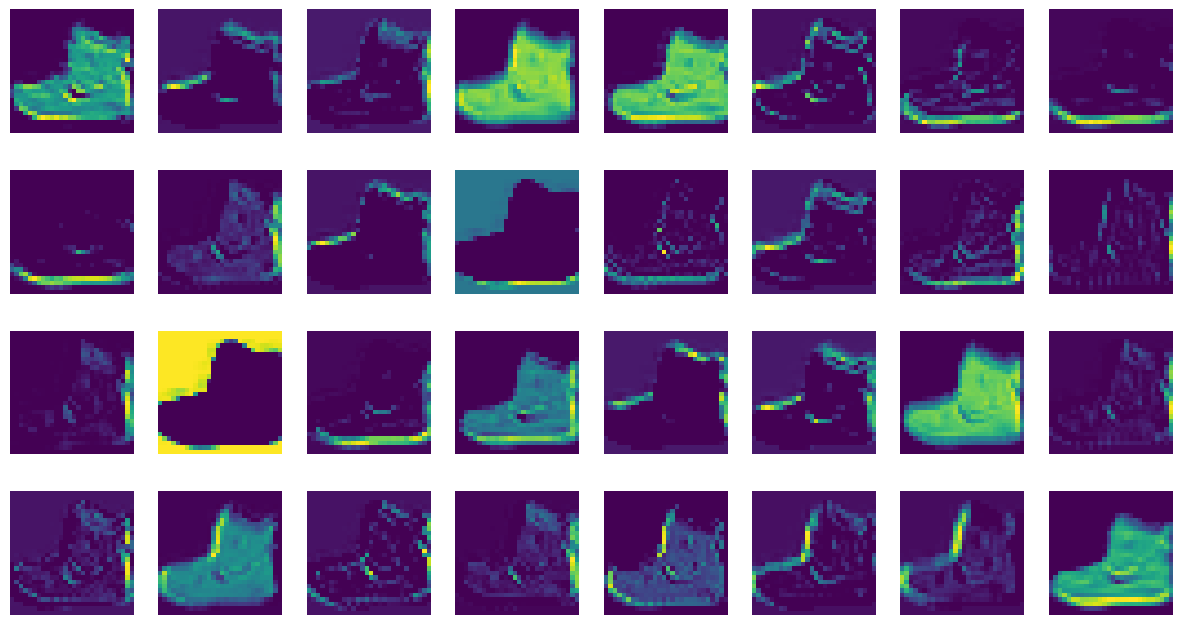

In [ ]:
# 맷플롯립의 imshow 함수로 특성 맵 그리기 - 이 특성 맵은 32개의 필터로 인해 입력 이미지에서 강하게 활성화된 부분을 보여 줌
fig, axs = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8+j]) 
        axs[i, j].axis('off')
plt.show()

In [24]:
# 두 번째 합성곱 층이 만든 특성 맵 확인
conv2_acti = keras.Model(model.inputs[0], model.layers[2].output)
feature_maps = conv2_acti.predict(ankle_boot)
print(feature_maps.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
(1, 14, 14, 64)


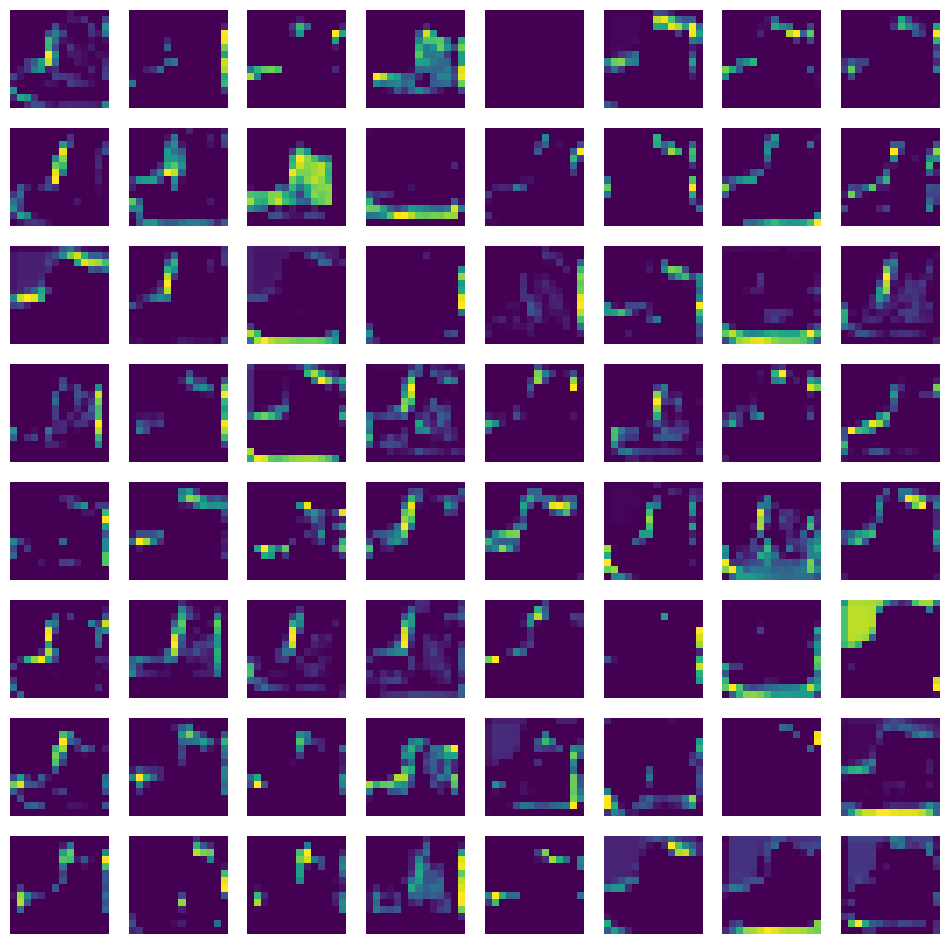

In [25]:
# 64개의 특성 맵을 8개씩 나누어 imshow() 함수로 그리기
fig, axs = plt.subplots(8, 8, figsize=(12,12))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8+j])
        axs[i, j].axis('off')
plt.show()

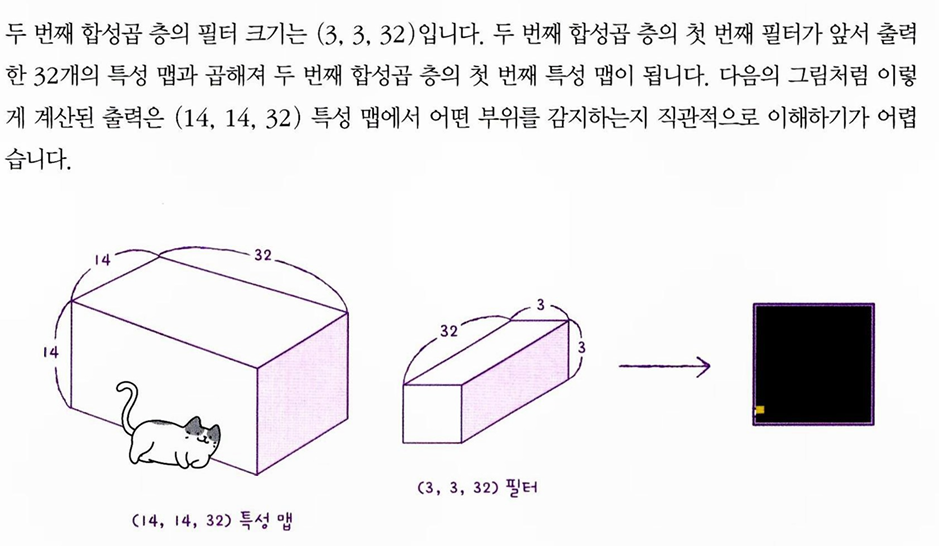

-> 합성곱 신경망의 앞부분의 합성곱 층은 이미지의 시각적인 정보를 감지, 뒷부분의 합성곱 층은 앞쪽에서 감지한 시각적인 정보를 바탕으로 추상적인 정보를 학습